# Nama : Andifa Naufal R
# Submission : Image Classification

#Intel Image



###Library


In [18]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt



###Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive

# mounting dataset from gdrive
drive.mount('/content/gdrive', force_remount=True)

# dataset path
root_path = '/content/gdrive/MyDrive/inteldataset.zip'

print("Path root:", root_path)

Mounted at /content/gdrive
Path root: /content/gdrive/MyDrive/inteldataset.zip


In [ ]:
!unzip /content/gdrive/MyDrive/intel_dataset.zip -d /content/gdrive/MyDrive

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/gdrive/MyDrive/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/gdr

In [ ]:
dataset = ['/content/gdrive/MyDrive/seg_test','/content/gdrive/MyDrive/seg_train']

In [ ]:
import shutil
import os


# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):
	
	# Path
	path = os.path.join(parent_folder, folder_name)
	
	# Create the folder
	# 'new_folder' in
	# parent_folder
	try:
		# mode of the folder
		mode = 0o777

		# Create folder
		os.mkdir(path, mode)
	except OSError as error:
		print(error)

# current folder path
current_folder = os.getcwd()

# list of folders to be merged
list_dir = dataset

# enumerate on list_dir to get the
# content of all the folders ans store
# it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
	path = os.path.join(current_folder, val)
	content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will
# be merged
merge_folder = "merge_folder"

# merge_folder path - current_folder
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

	# loop through the contents of the
	# list of folders
	for contents in content_list[sub_dir]:

		# make the path of the content to move
		path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
		dir_to_move = os.path.join(current_folder, path_to_content )

		# move the file
		shutil.move(dir_to_move, merge_folder_path)


###Preprocessing Data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2 #split data 
    
)
train_generator = train_datagenerator.flow_from_directory (
    '/content/merge_folder/seg_train',
    target_size = (150,150),
    shuffle = True,
    batch_size = 32,
    class_mode='categorical',
    subset  = 'training'
)
validation_generator = train_datagenerator.flow_from_directory(
    '/content/merge_folder/seg_train',
    target_size = (150,150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


###Build Model

In [39]:
model = Sequential ([
    Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout (0.5),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax') # layer output
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 128)      

###Compile Model

In [43]:
model.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.Adam(learning_rate=1.0000e-04),
             metrics=['accuracy'])

###Callbacks


In [44]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.85):
      print("\nAkurasi telah mencapai >=85%!")
      self.model.stop_training = True
callbacks = myCallback()

###Fit Model


In [45]:
history = model.fit(train_generator,
         batch_size=64,
         epochs=20,
         validation_data=validation_generator,
         verbose=2,
         callbacks=[callbacks])


Epoch 1/20
351/351 - 15s - loss: 1.1924 - accuracy: 0.5311 - val_loss: 0.9910 - val_accuracy: 0.6409
Epoch 2/20
351/351 - 14s - loss: 0.9179 - accuracy: 0.6564 - val_loss: 0.8637 - val_accuracy: 0.6797
Epoch 3/20
351/351 - 14s - loss: 0.8165 - accuracy: 0.6947 - val_loss: 0.7354 - val_accuracy: 0.7336
Epoch 4/20
351/351 - 13s - loss: 0.7451 - accuracy: 0.7224 - val_loss: 0.6787 - val_accuracy: 0.7553
Epoch 5/20
351/351 - 13s - loss: 0.6753 - accuracy: 0.7522 - val_loss: 0.6402 - val_accuracy: 0.7735
Epoch 6/20
351/351 - 13s - loss: 0.6342 - accuracy: 0.7636 - val_loss: 0.6301 - val_accuracy: 0.7700
Epoch 7/20
351/351 - 14s - loss: 0.5933 - accuracy: 0.7797 - val_loss: 0.5966 - val_accuracy: 0.7846
Epoch 8/20
351/351 - 14s - loss: 0.5556 - accuracy: 0.7988 - val_loss: 0.5648 - val_accuracy: 0.7992
Epoch 9/20
351/351 - 14s - loss: 0.5251 - accuracy: 0.8108 - val_loss: 0.5323 - val_accuracy: 0.8160
Epoch 10/20
351/351 - 14s - loss: 0.5151 - accuracy: 0.8116 - val_loss: 0.5761 - val_accura

### Plot 

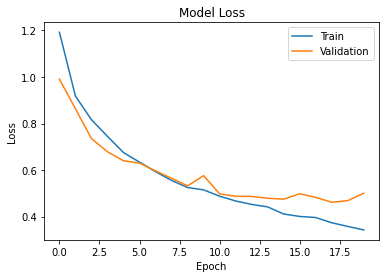

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

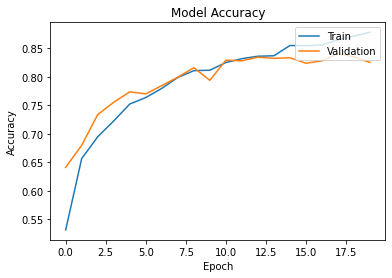

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

###Convert Model

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpnyzpz1jm/assets


###Save Model

In [49]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)